In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.odr import *
!git clone https://github.com/JCLMantilla/LabIntermedio

Cloning into 'LabIntermedio'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 22 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [ ]:
#aluminio=pd.read_excel(io="/content/LabIntermedio/actividad_2_aluminio.xlsx")
#zinc=pd.read_excel(io="/content/LabIntermedio/actividad_2_zinc.xlsx")
##########################################################################################################
aluminio=pd.read_csv(filepath_or_buffer="/content/LabIntermedio/actividad_2_aluminio.csv",delimiter=";",names=["angulo","0","0.2","0.4","0.6","0.8","1.0","1.2","1.4","1.6","1.8","2.0"])
zinc=pd.read_csv(filepath_or_buffer="/content/LabIntermedio/actividad_2_zinc.csv",delimiter=";",names=["angulo","0","0.25","0.50","0.75","1.00","1.25","1.50","1.75","2.00"])
##########################################################################################################
def get_uncertainty(number):
  number=str(number)
  point_pos=0
  dig=len(number)-1
  for i in range(len(number)):
    if number[i]==".":
      point_pos=i
  uncertainty=1/(10**(abs(dig-point_pos)))
  return uncertainty
def get_uncertainty_dframe(dframe):
  new_dframe=dframe.copy()
  for column in new_dframe.columns:
    for index in new_dframe.index:
      new_dframe.loc[index,column]=get_uncertainty(new_dframe.loc[index,column])
  return new_dframe
##########################################################################################################
aluminio_error=get_uncertainty_dframe(aluminio)
zinc_error=get_uncertainty_dframe(zinc)
#################################Vamos a pasar a metros los grosores y sus incertidumbres#########################################################################

grosor_aluminio=[float(x)*0.001 for x in aluminio.columns[1:]]
err_grosor_aluminio=[0.1*0.001 for x in aluminio.columns[1:]] 
grosor_zinc=[float(x)*0.001 for x in zinc.columns[1:]]
err_grosor_zinc=[0.01*0.001 for x in zinc.columns[1:]]

############### Corregimos las incertudumbres ya que vamos a normalizar las intensidades ###############
for ind in aluminio_error.index:
  for x in aluminio_error.columns[1:]:
    aluminio_error[x][ind]=aluminio_error[x][ind]/aluminio["0"][ind]
for ind in zinc_error.index:
  for x in zinc_error.columns[1:]:
    zinc_error[x][ind]=zinc_error[x][ind]/zinc["0"][ind]
############### Normalizamos las intensidades de los dframe de Al y Zn ###############
aluminio_copy=aluminio.copy()
zinc_copy=zinc.copy()
for ind in aluminio.index:
  for x in aluminio.columns[1:]:
    aluminio[x][ind]=aluminio[x][ind]/aluminio_copy["0"][ind]
for ind in zinc.index:
  for x in zinc.columns[1:]:
    zinc[x][ind]=zinc[x][ind]/zinc_copy["0"][ind]
############### Vamos a transformar los angulos en longitudes de onda, y vamos a transformar los errores respectivosp para Al y Zn
d=2.014e-10 # Distancia interplanar del Lif en metros

aluminio_error["angulo"]=np.abs(2*d*aluminio_error["angulo"]*np.cos(aluminio["angulo"]))
aluminio["angulo"]=2*d*np.sin(aluminio["angulo"])

zinc_error["angulo"]=np.abs(2*d*zinc_error["angulo"]*np.cos(zinc["angulo"]))
zinc["angulo"]=2*d*np.sin(zinc["angulo"])
######### Ya con esto tenemos los datos preparados para hacer las regresiones

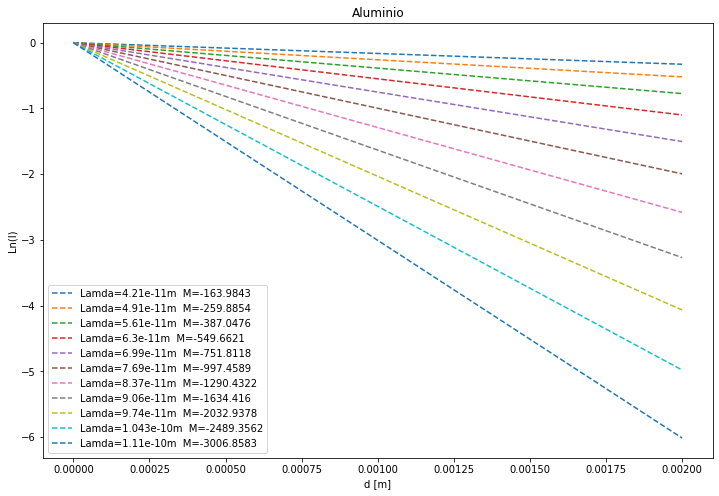

,Lambda,Mu,Mu_error
0,4.210407e-11,-163.984295,0.005470
1,4.908897e-11,-259.885371,0.050396
2,5.605893e-11,-387.047600,0.000008
3,6.301180e-11,-549.662078,0.456277
4,6.994549e-11,-751.811802,0.563925
5,7.685786e-11,-997.458852,0.000043
6,8.374683e-11,-1290.432218,0.473991
7,9.061028e-11,-1634.416015,0.410161
8,9.744614e-11,-2032.937792,1.146401
9,1.042523e-10,-2489.356192,0.055285


In [ ]:
def f(B, x):
    return B[0]*x + B[1]
#################Vamos a hacer las regresiones para el aluminio######################



mu_aluminio=[]
err_mu_aluminio=[]

plt.figure(figsize=(12,8))
plt.title("Aluminio")
for fila in aluminio.index:
  linear = Model(f)
  mydata = RealData(grosor_aluminio, np.log(aluminio.loc[[fila],"0":]), sx=err_grosor_aluminio,sy=np.abs(aluminio_error.loc[[fila],"0":]*1/(aluminio.loc[[fila],"0":])))
  myodr = ODR(mydata, linear, beta0=[0,1])
  myoutput = myodr.run()
  #myoutput.pprint()
  pendiente,corte=myoutput.beta
  pendiente_error,_=myoutput.sd_beta
  mu_aluminio.append(pendiente)
  err_mu_aluminio.append(pendiente_error)
  x_fit=np.linspace(grosor_aluminio[0],grosor_aluminio[len(grosor_aluminio)-1],100)
  y_fit=pendiente*x_fit+corte
  #plt.errorbar(grosor_aluminio,np.log(aluminio.loc[[fila],"0":]),np.abs(aluminio_error.loc[[fila],"0":]*1/(aluminio.loc[[fila],"0":])), err_grosor_aluminio, ecolor="black",elinewidth=1,linestyle='--',fmt="none")
  plt.plot(x_fit,y_fit,linestyle='--',label="Lamda="+str(np.round(aluminio["angulo"][fila],13))+"m  "+"M="+str(np.round(pendiente,4)))
plt.legend()
plt.xlabel("d [m]")
plt.ylabel("Ln(I)")
plt.show()

datos_melos_al=pd.DataFrame({"Lambda":aluminio["angulo"],"Mu":mu_aluminio,"Mu_error":err_mu_aluminio})
datos_melos_al

In [1]:
##################################Vamos a hacer las regresiones para el Zinc
mu_zinc=[]
err_mu_zinc=[]

def f(B, x):
    return B[0]*x + B[1]

plt.figure(figsize=(12,8))
plt.title("Zinc")
for fila in zinc.index:
  linear = Model(f)
  mydata = RealData(grosor_zinc, np.log(zinc.loc[[fila],"0":]), sx=err_grosor_zinc,sy=np.abs(zinc_error.loc[[fila],"0":]*1/(zinc.loc[[fila],"0":])))
  myodr = ODR(mydata, linear, beta0=[0,1])
  myoutput = myodr.run()
  #myoutput.pprint()
  pendiente,corte=myoutput.beta
  pendiente_error,_=myoutput.sd_beta
  mu_zinc.append(pendiente)
  err_mu_zinc.append(pendiente_error)
  x_fit=np.linspace(grosor_zinc[0],grosor_zinc[len(grosor_zinc)-1],100)
  y_fit=pendiente*x_fit+corte
  if pendiente!=0.0:
    plt.plot(x_fit,y_fit,linestyle='--',label="Lamda="+str(np.round(zinc["angulo"][fila],13))+"m  "+"M="+str(np.round(pendiente,4)))
plt.legend()
plt.xlabel("d [m]")
plt.ylabel("Ln(I)")
plt.show()

datos_melos_zn=pd.DataFrame({"Lambda":zinc["angulo"],"Mu":mu_zinc,"Mu_error":err_mu_zinc})
datos_melos_zn


NameError: ignored

In [ ]:
zinc_error

,angulo,0,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00
0,4.005934e-18,1.445087e-03,0.001445,0.001445,1.445087e-03,1.445087e-04,1.445087e-04,1.445087e-04,1.445087e-18,1.445087e-04
1,3.997976e-18,9.174312e-03,0.000917,0.000917,9.174312e-05,9.174312e-05,9.174312e-05,9.174312e-06,9.174312e-06,9.174312e-06
2,3.988800e-18,7.874016e-03,0.000787,0.000787,7.874016e-05,7.874016e-05,7.874016e-06,7.874016e-06,7.874016e-20,7.874016e-06
3,3.978409e-18,7.633588e-03,0.000763,0.000076,7.633588e-06,7.633588e-06,7.633588e-20,7.633588e-05,7.633588e-06,7.633588e-06
4,3.966806e-18,7.936508e-03,0.000794,0.000079,7.936508e-06,7.936508e-06,7.936508e-06,7.936508e-20,7.936508e-05,7.936508e-06
5,3.953994e-18,8.547009e-17,0.000085,0.000009,8.547009e-20,8.547009e-06,8.547009e-06,8.547009e-06,8.547009e-20,8.547009e-06
6,3.939979e-18,9.523810e-03,0.000095,0.000010,9.523810e-19,9.523810e-20,9.523810e-06,9.523810e-20,9.523810e-06,9.523810e-20
7,3.924763e-27,1.083424e-03,0.000011,0.000011,1.083424e-05,1.083424e-19,1.083424e-05,1.083424e-05,1.083424e-05,1.083424e-04
8,3.908351e-17,1.250000e-01,0.000012,0.000012,1.250000e-05,1.250000e-05,1.250000e-19,1.250000e-05,1.250000e-18,1.250000e-05
9,3.890749e-18,1.459854e-03,0.000015,0.000015,1.459854e-05,1.459854e-05,1.459854e-19,1.459854e-18,1.459854e-05,1.459854e-05
